In [2]:
# initial imports

import h5py
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle
import pandas as pd

import torchvision
import torch
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim


import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
# Set session, bins
year = '2024'
month = '04'
day = '03'

start_bin = -.1
end_bin = .301
blank_or_nonblank = 'blank'

In [4]:
# Load the data

pathname = f'/Users/parsatalaie/Desktop/Marmoset Datasets/{year}{month}{day}_all_psth.h5'

f = h5py.File(pathname)
list(f.keys())

['data',
 'site_coordinates',
 'stim_indices',
 'trial_params',
 'trial_params_short']

In [14]:
# Add path to and import mkturk analysis tools

from sys import path

print(path)

path.append('/Users/parsatalaie/Desktop/Issa Data')

from data_analysis_tools_mkTurk.utils_meta import get_recording_path
from data_analysis_tools_mkTurk.general import df_2_psth_mat
from data_analysis_tools_mkTurk.IO import ch_dicts_2_h5, h5_2_trial_df, h5_2_df

['/Users/parsatalaie/Desktop/Marmoset Data Analysis', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa']


/Users/parsatalaie/Desktop/Issa Data/data_analysis_tools_mkTurk/general.py:22: UserWarning: Failed to import analysis_metadata module.
  warnings.warn('Failed to import analysis_metadata module.')
/Users/parsatalaie/Desktop/Issa Data/data_analysis_tools_mkTurk/IO.py:19: UserWarning: Failed to import analysis_metadata module.
  warnings.warn('Failed to import analysis_metadata module.')


In [ ]:
'''
Check if issue is filtering of df: start with all trials
'''

In [18]:
# h5_2_df the whole file (same time_window)

time_window = [start_bin, end_bin]
all_data = h5_2_df(pathname, time_window=time_window)

Fetching trial parameters...
... done (0.025144100189208984 sec).
Pre-fetching PSTHs from HDF5...


/opt/anaconda3/lib/python3.12/site-packages/tables/attributeset.py:290: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


... done.
Duration=0.009792168935139975 minutes
Fancy slicing numpy array...
... done.
Duration=0.01616644859313965 minutes


In [ ]:
# Apply masks

nan_mask = all_data.apply(lambda x : np.all(np.isnan(x.psth)), axis=1)
fix_all_data = all_data[-mask]
scenefile_mask = fix_all_data['scenefile'] == '/mkturkfiles/scenebags/West/20231025_Rust_NaturalImages300_300ms.json'
final_all_data = fix_all_data[scenefile_mask]

In [226]:
# Convert trial_num, rsvp_num to int64 (for some reason)

final_all_data['trial_num'] = final_all_data['trial_num'].astype('int64')
final_all_data['rsvp_num'] = final_all_data['rsvp_num'].astype('int64')

In [229]:
# Check if equivalent

try:
    pd.testing.assert_frame_equal(final_all_data, fixed_rust_data)
    print("DataFrames are identical")
except AssertionError:
    print("DataFrames are different")

DataFrames are identical


In [ ]:
# If want to merge rsvp and trial columns

all_data['rsvp_num'] = all_data['rsvp_num'].astype('str')

all_data['trial_num'] = all_data['trial_num'].astype('str')

all_data['trial_num'].str.cat(all_data['rsvp_num'], sep='')

In [41]:
# Create, print trial_params

trial_params = h5_2_trial_df(pathname)

/opt/anaconda3/lib/python3.12/site-packages/tables/attributeset.py:290: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


In [42]:
# List scenefiles

trial_params['scenefile'].unique()

array(['/mkturkfiles/scenebags/West/20231025_Rust_NaturalImages300_300ms.json',
       '/mkturkfiles/scenebags/West/20231025_Var6vbslir_set0_im151_elias_dur300ms_lab_updated.json',
       '/mkturkfiles/scenebags/West/20231025_Var6vbslir_set0_im151_neptune_dur300ms_lab_updated.json',
       '/mkturkfiles/scenebags/West/BlankStim_300ms.json',
       '/mkturkfiles/scenebags/West/neural_stim_4_0ABCDEFGHIJ.json'],
      dtype=object)

In [45]:
# Rust
scenefiles = ['/mkturkfiles/scenebags/West/20231025_Rust_NaturalImages300_300ms.json']

In [44]:
# HvM
scenefiles = ['/mkturkfiles/scenebags/West/hvm10_table_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_elephant_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_dog_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_bear_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_chair_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_car_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_turtle_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_plane_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_apple_45_20240906.json',
       '/mkturkfiles/scenebags/West/hvm10_head_45_20240906.json']

In [122]:
# Select stimulus presentations associated with requested scenefiles:
filter = trial_params.scenefile.isin(scenefiles)
rust_trials = trial_params[filter]
array_filter = np.array(rust_trials[['trial_num', 'rsvp_num']])

# Read spike count data from HDF5 for requested trials:
time_window = [start_bin, end_bin] # Beginning and end of peristimulus time window for each stim, relative to trigger in seconds
df_filt_rust_data = h5_2_df(pathname, trials=rust_trials, time_window=time_window)
arr_filt_rust_data = h5_2_df(pathname, trials=array_filter, time_window=time_window)


# Sort rust_data to match trial_params, rust_trials
df_filt_rust_data.sort_index(inplace=True)
arr_filt_rust_data.sort_index(inplace=True)

# Create spikes df
spikes = df_2_psth_mat(rust_data)
ch_tot = spikes.shape[0]
bin_tot = spikes.shape[1]
stim_tot = spikes.shape[2]

Pre-fetching PSTHs from HDF5...
... done.
Duration=0.008795066674550375 minutes
Fancy slicing numpy array...
... done.
Duration=0.008574716250101725 minutes
Fetching trial parameters...
... done (0.011053085327148438 sec).
inds_df.shape = (4050, 2)


/opt/anaconda3/lib/python3.12/site-packages/tables/attributeset.py:290: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


Pre-fetching PSTHs from HDF5...
... done.
Duration=0.007747415701548258 minutes
Fancy slicing numpy array...
... done.
Duration=0.006803731123606364 minutes


In [145]:
test = 0
for i in range(4050):
    compare = (arr_filt_rust_data['psth'].iloc[i] == df_filt_rust_data['psth'].iloc[i])
    if np.all(compare):
        test += 1

test

3364

In [ ]:
'''
Use masking to get rid of nan
'''

In [117]:
# Create mask
mask = rust_data.apply(lambda x : np.all(np.isnan(x.psth)), axis=1)

In [158]:
df_mask = df_filt_rust_data.apply(lambda x : np.all(np.isnan(x.psth)), axis=1)
arr_mask = arr_filt_rust_data.apply(lambda x : np.all(np.isnan(x.psth)), axis=1)

In [172]:
arr_filt_rust_data = arr_filt_rust_data[-arr_mask]
arr_filt_rust_data = df_filt_rust_data[-df_mask]

In [ ]:
arr_filt_rust_data_prime = arr_filt_rust_data.copy()
X = df_filt_rust_data['psth']
arr_filt_rust_data_prime['psth_prime'] = X
c = arr_filt_rust_data_prime.apply(lambda  x : np.all(x.psth==x.psth_prime), axis=1)

D = pd.merge(arr_filt_rust_data[['trial_num', 'rsvp_num', 'psth']], df_filt_rust_data[['trial_num', 'rsvp_num', 'psth']], on=['trial_num', 'rsvp_num'])

D.apply(lambda x : np.all(x.psth_x==x.psth_y), axis=1).sum()

In [156]:
arr_filt_rust_data = arr_filt_rust_data.drop(columns = 'psth_hat')

In [119]:
final_data = rust_data[-mask]

In [121]:
final_data.shape

(7086, 11)

In [47]:
# get idx of nan stimuli, check if same for all channels

equ = 0

test_ch = spikes[0]
nan_idx = np.zeros((stim_tot))

for column_index in range(stim_tot):
    nan_tot = np.isnan(test_ch[:, column_index]).sum()
    if nan_tot == bin_tot:
        nan_idx[column_index] = True
nan_idx_arr_0 = np.where(nan_idx == True)[0]

for ch in range(ch_tot):
    test_ch = spikes[ch]
    nan_idx = np.zeros((stim_tot))
    for column_index in range(stim_tot):
        nan_tot = np.isnan(test_ch[:, column_index]).sum()
        if nan_tot == bin_tot:
            nan_idx[column_index] = True
    nan_idx_arr = np.where(nan_idx == True)[0]
    if np.array_equal(nan_idx_arr, nan_idx_arr_0):
        equ += 1

if equ == ch_tot:
    print('Truth!')

Truth!


In [48]:
print(f'Number of usable trials: {stim_tot-nan_idx_arr.shape[0]}')

Number of usable trials: 3364


In [18]:
'''
Delete unusable trials from dataframe instead of spikes
Create fixed spikes, average it
'''

'\nDelete unusable trials from dataframe instead of spikes\nCreate fixed spikes, average it\n'

In [49]:
### Create fixed_rust_data, fixed_spikes (remove nan trials)
# Reset indices (helps when removing unusable stimuli)
rust_data.reset_index(drop=True, inplace=True)
fixed_rust_data = rust_data.drop(nan_idx_arr)
fixed_spikes = df_2_psth_mat(fixed_rust_data)
fixed_spikes.shape

(384, 40, 3364)

In [50]:
# Check for remaining nan
np.isnan(fixed_spikes).sum()

0

In [51]:
# Create avg_spikes
avg_spikes = np.mean(fixed_spikes, axis=1)
avg_spikes.shape

(384, 3364)

In [22]:
'''
Create natimg_path_list
'''

'\nCreate natimg_path_list\n'

In [52]:
# RUST NATIMG_PATH_LIST
natimg_path_list = []

for i in fixed_rust_data['stim_idx']:
    natimg_path_list.append(f'/Users/parsatalaie/Downloads/rust_natimgs/Nat300_{i+1}.png')

len(natimg_path_list)

3364

In [65]:
# HVM NATIMG_PATH_LIST
start_idx = 51
alter_hvm_path = lambda hvm_path : '/Users/parsatalaie/Desktop/Marmoset Datasets/' + hvm_path[start_idx:]
natimg_paths = fixed_rust_data['img_full_path'].apply(alter_hvm_path)
natimg_path_list = natimg_paths.tolist()
len(natimg_path_list)

3364

In [ ]:
'''
Compare to 2024 natimg_path_list
'''

In [53]:
# load good (2024) natimg_path_list

with open(f'./2024_{month}_{day}/natimg_path_list_2024{month}{day}', 'rb') as fp:   # Unpickling
    tt4_natimg_path_list = pickle.load(fp)

In [56]:
tt4_sorted_paths = [int(path[:-4][49:]) for path in tt4_natimg_path_list]
tt4_sorted_paths.sort()

In [242]:
sorted_paths = np.sort(np.array(fixed_rust_data['stim_idx']))

In [246]:
unique, counts = np.unique(np.array(test_list), return_counts=True)
test_counts = dict(zip(unique, counts))

In [59]:
(np.array(tt4_sorted_paths) == np.sort(np.array(fixed_rust_data['stim_idx']))+1)[:50]

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True,  True,  True,  True])

In [60]:
unique, counts = np.unique(np.array(tt4_sorted_paths), return_counts=True)
tt4_counts = dict(zip(unique, counts))

In [251]:
unique, counts = np.unique((np.array(fixed_rust_data['stim_idx']))+1, return_counts=True)
new_counts = dict(zip(unique, counts))

In [62]:
tt4_counts

{1: 11,
 2: 9,
 3: 14,
 4: 12,
 5: 9,
 6: 14,
 7: 11,
 8: 9,
 9: 12,
 10: 10,
 11: 13,
 12: 11,
 13: 7,
 14: 12,
 15: 10,
 16: 11,
 17: 9,
 18: 10,
 19: 13,
 20: 11,
 21: 13,
 22: 13,
 23: 10,
 24: 14,
 25: 14,
 26: 13,
 27: 13,
 28: 13,
 29: 13,
 30: 9,
 31: 13,
 32: 13,
 33: 9,
 34: 8,
 35: 11,
 36: 12,
 37: 11,
 38: 10,
 39: 13,
 40: 11,
 41: 14,
 42: 12,
 43: 13,
 44: 13,
 45: 13,
 46: 7,
 47: 12,
 48: 11,
 49: 13,
 50: 12,
 51: 13,
 52: 10,
 53: 12,
 54: 11,
 55: 9,
 56: 11,
 57: 14,
 58: 11,
 59: 10,
 60: 12,
 61: 12,
 62: 9,
 63: 13,
 64: 13,
 65: 13,
 66: 9,
 67: 8,
 68: 14,
 69: 9,
 70: 10,
 71: 11,
 72: 14,
 73: 12,
 74: 15,
 75: 12,
 76: 11,
 77: 11,
 78: 11,
 79: 13,
 80: 10,
 81: 12,
 82: 12,
 83: 10,
 84: 10,
 85: 7,
 86: 10,
 87: 11,
 88: 9,
 89: 12,
 90: 9,
 91: 13,
 92: 12,
 93: 14,
 94: 10,
 95: 11,
 96: 10,
 97: 13,
 98: 11,
 99: 11,
 100: 5,
 101: 11,
 102: 12,
 103: 10,
 104: 14,
 105: 13,
 106: 10,
 107: 14,
 108: 8,
 109: 10,
 110: 13,
 111: 13,
 112: 14,
 113: 1

In [63]:
new_counts

{1: 8,
 2: 11,
 3: 12,
 4: 9,
 5: 13,
 6: 11,
 7: 8,
 8: 11,
 9: 9,
 10: 12,
 11: 9,
 12: 9,
 13: 8,
 14: 10,
 15: 8,
 16: 10,
 17: 12,
 18: 11,
 19: 11,
 20: 11,
 21: 11,
 22: 9,
 23: 11,
 24: 11,
 25: 10,
 26: 12,
 27: 11,
 28: 12,
 29: 11,
 30: 8,
 31: 10,
 32: 12,
 33: 10,
 34: 11,
 35: 14,
 36: 9,
 37: 12,
 38: 13,
 39: 10,
 40: 11,
 41: 13,
 42: 14,
 43: 12,
 44: 10,
 45: 10,
 46: 10,
 47: 13,
 48: 11,
 49: 13,
 50: 7,
 51: 10,
 52: 12,
 53: 13,
 54: 11,
 55: 11,
 56: 7,
 57: 10,
 58: 14,
 59: 10,
 60: 9,
 61: 11,
 62: 9,
 63: 12,
 64: 10,
 65: 12,
 66: 9,
 67: 12,
 68: 13,
 69: 11,
 70: 12,
 71: 13,
 72: 12,
 73: 11,
 74: 12,
 75: 11,
 76: 13,
 77: 8,
 78: 10,
 79: 11,
 80: 10,
 81: 13,
 82: 13,
 83: 11,
 84: 12,
 85: 11,
 86: 11,
 87: 10,
 88: 12,
 89: 11,
 90: 10,
 91: 9,
 92: 15,
 93: 13,
 94: 12,
 95: 10,
 96: 9,
 97: 10,
 98: 10,
 99: 12,
 100: 10,
 101: 11,
 102: 13,
 103: 12,
 104: 11,
 105: 9,
 106: 11,
 107: 10,
 108: 9,
 109: 11,
 110: 11,
 111: 12,
 112: 12,
 113: 9,


In [43]:
starting_index = 0
start_idx_arr = []
for i in counts:
    starting_index += counts[i]
    start_idx_arr.append(starting_index)

In [44]:
starting_index = 0
tt4_start_idx_arr = []
for i in tt4_counts:
    starting_index += tt4_counts[i]
    tt4_start_idx_arr.append(starting_index)

In [54]:
np.array(start_idx_arr) - np.array(tt4_start_idx_arr)

array([ -3,  -1,  -3,  -6,  -2,  -5,  -8,  -6,  -9,  -7, -11, -13, -12,
       -14, -16, -17, -14, -13, -15, -15, -17, -21, -20, -23, -27, -28,
       -30, -31, -33, -34, -37, -38, -37, -34, -31, -34, -33, -30, -33,
       -33, -34, -32, -33, -36, -39, -36, -35, -35, -35, -40, -43, -41,
       -40, -40, -38, -42, -46, -43, -43, -46, -47, -47, -48, -51, -52,
       -52, -48, -49, -47, -45, -43, -45, -46, -49, -50, -48, -51, -52,
       -54, -54, -53, -52, -51, -49, -45, -44, -45, -42, -43, -42, -46,
       -43, -44, -42, -43, -44, -47, -48, -47, -42, -42, -41, -39, -42,
       -46, -45, -49, -48, -47, -49, -50, -52, -56, -57, -57, -56, -53,
       -56, -50, -51, -52, -55, -54, -52, -48, -47, -45, -45, -44, -45,
       -44, -49, -48, -45, -45, -42, -41, -39, -40, -40, -42, -44, -44,
       -42, -42, -43, -39, -40, -41, -35, -31, -33, -29, -29, -31, -34,
       -30, -32, -29, -26, -27, -30, -31, -30, -28, -27, -28, -26, -23,
       -15, -14, -12, -15, -17, -21, -20, -17, -15, -15, -14, -1

In [66]:
'''
Save spikes, natimg_path_list
'''

'\nSave spikes, natimg_path_list\n'

In [47]:
# Save avg_spikes
np.save(f'./{year}_{month}_{day}/marm_avg_spikes_{year}{month}{day}', avg_spikes)

In [48]:
# pickle it

import pickle

with open(f'./{year}_{month}_{day}/natimg_path_list_{year}{month}{day}', 'wb') as fp:   #Pickling
    pickle.dump(natimg_path_list, fp)

In [ ]:
# Get demon matrix for blank stims
img_count = len(set(natimg_path_list))
img_spikes_tot = np.zeros((ch_tot, max_reps, img_count))

for ch in range(ch_tot):
    neuron = marm_avg_spikes[:, ch]
    count_arr = np.zeros((max_reps, img_count))
    count_arr[:] = np.nan
    for i in blank_stims_idx:
        path = f'/Users/parsatalaie/Downloads/rust_natimgs/Nat300_{i+1}.png'
        idx_list = [i for i, j in enumerate(natimg_path_list) if j == path]
        for rep, idx in enumerate(idx_list):
            count_arr[rep, i] = neuron[idx]
    img_spikes_tot[ch] = count_arr

In [32]:
# Create new_ch_depth

coords = f['site_coordinates']
depth_ch_idx = coords['axis1'][:]

new_ch_depth = np.zeros((384))

for i in range(384):
    idx = depth_ch_idx[i]
    new_ch_depth[i] = coords['block0_values'][:][:, 3][idx]

In [33]:
# Save list of ch depths

np.save(f'./{year}_{month}_{day}/ch_depth_{year}{month}{day}', new_ch_depth)

In [35]:
avg_spikes

array([[0.125, 0.15 , 0.225, ..., 0.   , 0.   , 0.075],
       [0.175, 0.125, 0.375, ..., 0.075, 0.05 , 0.   ],
       [0.025, 0.   , 0.225, ..., 0.025, 0.   , 0.   ],
       ...,
       [0.325, 0.   , 0.05 , ..., 0.05 , 0.   , 0.025],
       [0.375, 0.   , 0.075, ..., 0.   , 0.   , 0.   ],
       [0.025, 0.075, 0.275, ..., 0.075, 0.125, 0.025]])

In [27]:
# Site coords df (if necessary)

site_coords_df = pd.read_hdf(pathname, 'site_coordinates', 'r')

/opt/anaconda3/lib/python3.12/site-packages/tables/attributeset.py:290: DataTypeWarning: Unsupported type for attribute 'scenefile_by_stim_mat' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


In [14]:
# Goal: get idx of blank_stims

blank_stims_idx = []
blank_img_idx = np.array([301, 302, 303, 304, 305]) - 1

for i in blank_img_idx:
    path = f'/Users/parsatalaie/Downloads/rust_natimgs/Nat300_{i+1}.png'
    idx_list = [i for i, j in enumerate(natimg_path_list) if j == path]
    for idx in idx_list:
        blank_stims_idx.append(idx)

print(len(blank_stims_idx))

51


In [13]:
# load natimg_path_list

with open(f'./{year}_{month}_{day}/natimg_path_list_{year}{month}{day}', 'rb') as fp:   # Unpickling
    natimg_path_list = pickle.load(fp)

len(natimg_path_list)

FileNotFoundError: [Errno 2] No such file or directory: './2024_11_08/natimg_path_list_20241108'

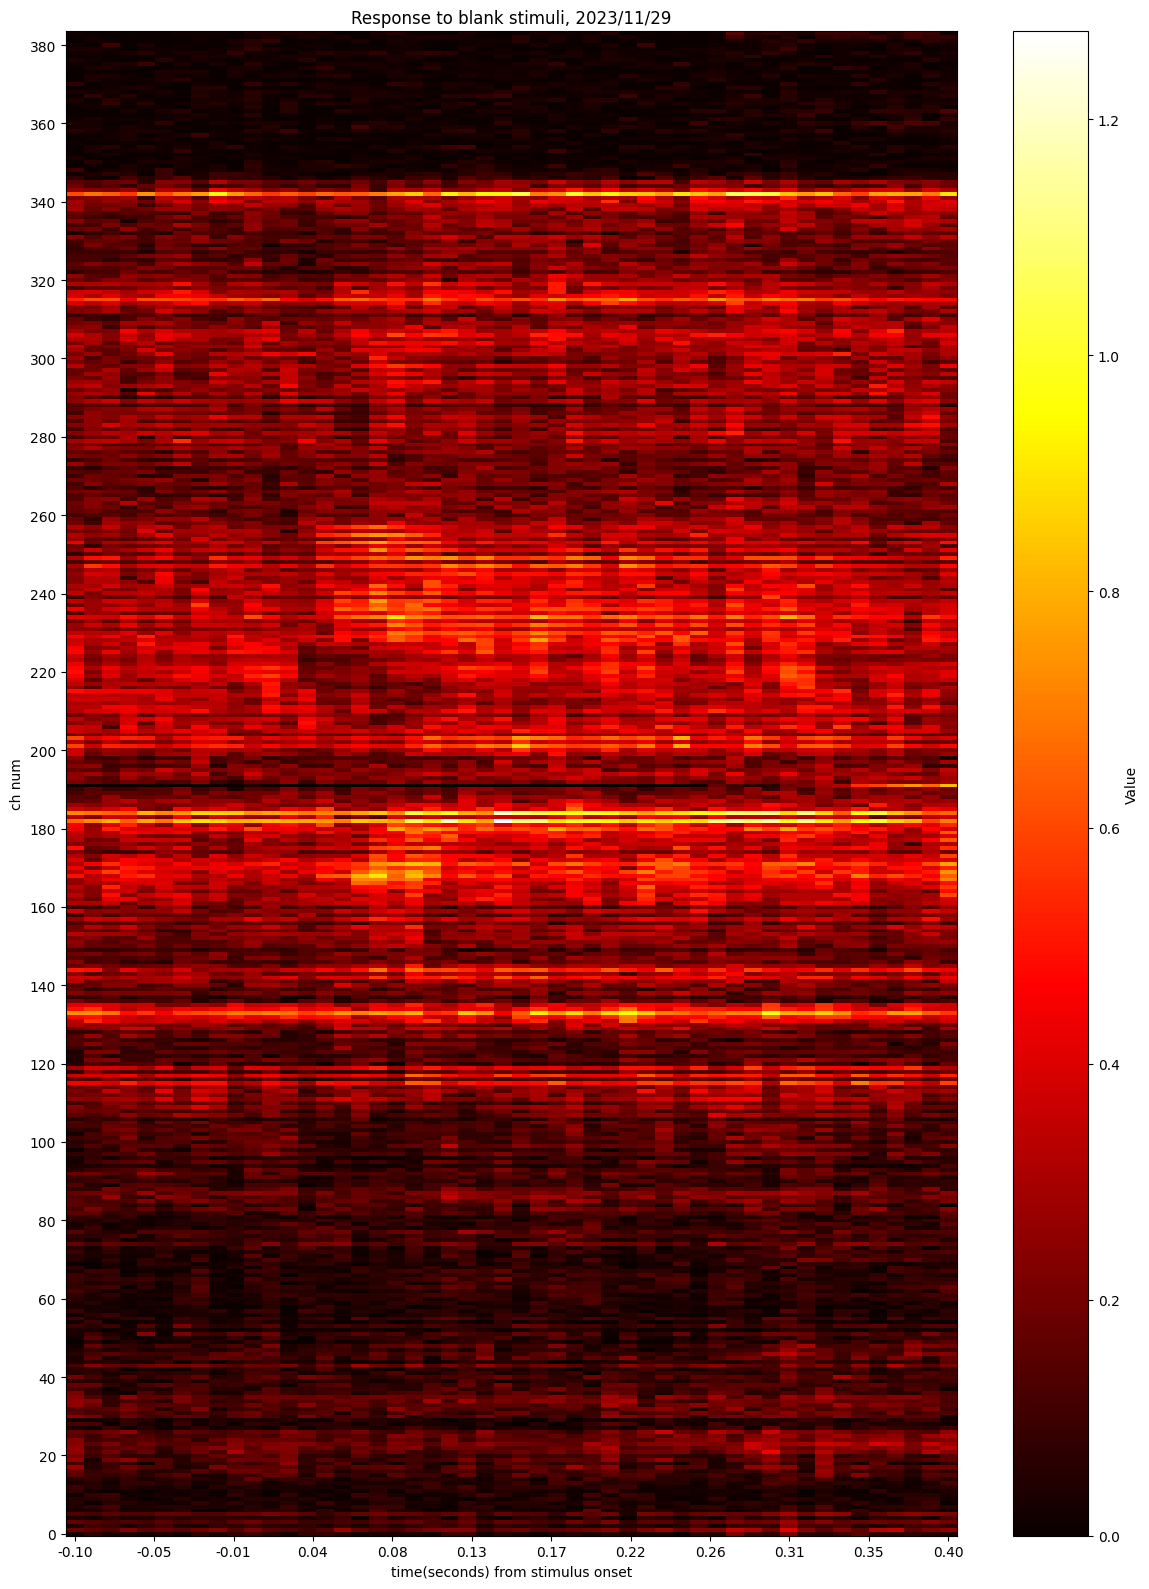

In [18]:
# Plot bins for regular stims
if blank_or_nonblank == 'nonblank':
    data = np.delete(fixed_spikes, blank_stims_idx, axis=2).mean(axis=2)
elif blank_or_nonblank == 'blank':
    data = fixed_spikes[:, :, blank_stims_idx].mean(axis=2)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 16))

# Plot the heatmap
im = ax.imshow(data, aspect='auto', cmap='hot', interpolation='nearest')

# Set the colorbar
cbar = plt.colorbar(im)
cbar.set_label('Value')

# Set labels and title
ax.set_xlabel('time(seconds) from stimulus onset')
ax.set_ylabel('ch num')
ax.set_title(f'Response to {blank_or_nonblank} stimuli, {year}/{month}/{day}')

# Set x-axis ticks and labels'
num_xticks = 12
x_ticks = np.linspace(0, bin_tot-1, num_xticks)
x_labels = [f'{x:.2f}' for x in np.linspace(-0.1, 0.4, num_xticks)]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

# Set y-axis ticks and labels
y_ticks = np.arange(0, 383, 20)
ax.set_yticks(y_ticks)

# Invert the y-axis
ax.invert_yaxis()

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig(f'./{year}_{month}_{day}/{blank_or_nonblank}_responses_{year}{month}{day}')
plt.show()

In [20]:
# Get bin fire avgs

bin_fire_avg = np.zeros((bin_tot))

for i in range(bin_tot):
    bin_fire_avg[i] = np.mean(fixed_spikes[:, i, :])

print(bin_fire_avg)

[0.09341635 0.09432518 0.09694715 0.10231573 0.1113289  0.11779906
 0.12005874 0.11758463 0.11367528 0.11045723 0.10871777 0.10831444]


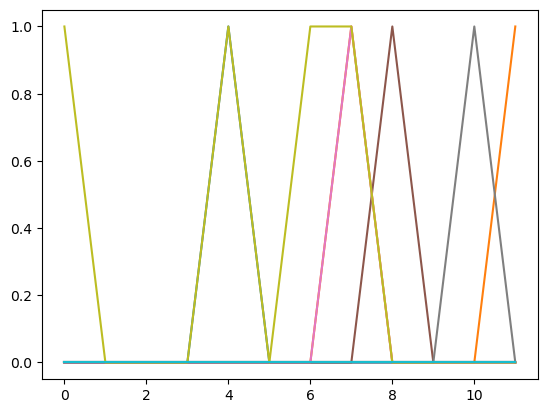

In [21]:
# Create some plots to check for visual drive

fixed_stim_tot = fixed_spikes.shape[2]

stim_test = 100
for i in range(10):
    plt.plot(fixed_spikes[10*i, :, stim_test])

plt.show()

In [23]:
# Compare firing for blank/all stim

blank_fire_avg = np.zeros((bin_tot))

for i in range(bin_tot):
    blank_fire_avg[i] = np.mean(fixed_spikes[:, i, 3313:3364])

print(f'Firing for blank stims: {blank_fire_avg[13:31].mean()}')

print(f'Firing for all stims: {bin_fire_avg[13:31].mean()}')

Firing for blank stims: nan
Firing for all stims: nan


/var/folders/y0/qxlgfr6961b36tyhj2p5y0c00000gn/T/ipykernel_51411/438928454.py:8: RuntimeWarning: Mean of empty slice.
  print(f'Firing for blank stims: {blank_fire_avg[13:31].mean()}')
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/y0/qxlgfr6961b36tyhj2p5y0c00000gn/T/ipykernel_51411/438928454.py:10: RuntimeWarning: Mean of empty slice.
  print(f'Firing for all stims: {bin_fire_avg[13:31].mean()}')
